In [1]:
import numpy as np
import pandas as pd
import string


# Pour visualisation
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# import seaborn as sns
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Pour NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize

# Pour Machine Learing - classification
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.metrics.cluster import adjusted_rand_score

# Partie 1 : Préprocession

## Charger les données
   <span style="color: #00FFFF">  @ Télécharger le fichier de format csv et puis le palce dans un dataframe nommé `loandown`. Les colonnes du fichier sont uniquement séparées par le caractère virgule. </span>

<span style="color: #00FFFF"> @ On afficher les 5 premières lignes du dataframe pour vérifier que les données sont bien chargées dans le dataframe `loandown` et sa taille. </span>

In [2]:
loandown = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv', sep=',')
print("La taille du dataframe est : ", loandown.shape)
loandown.info()

La taille du dataframe est :  (1050, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null

<span style="color: #00FFFF"> @ On afficher les valeurs manquantes dans le dataframe `loandown`. </span>

Text(0.5, 1.0, 'Missing value in the dataset')

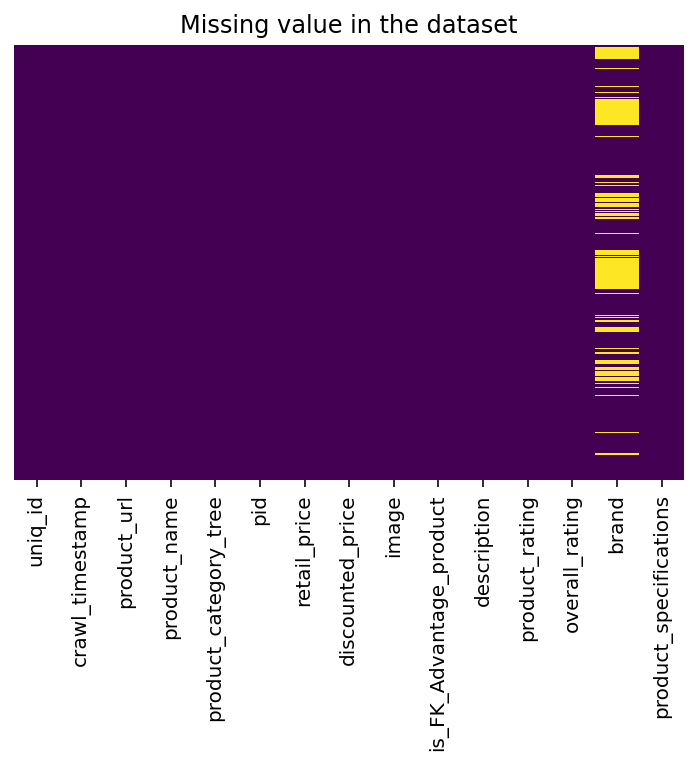

In [3]:
plt.Figure(figsize=(12,4))
sns.heatmap(loandown.isnull(), cbar=False, cmap= 'viridis', yticklabels=False)
plt.title('Missing value in the dataset')

<span style="color: #00FFFF"> @ On copie 4 colonnes dans un nouveau dataset appelé `data` que l'on utilise par la suite. </span>

In [4]:
data = loandown[['product_name', 'product_category_tree','image','description']]
data.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

<span style="color: #00FFFF"> @ On combine les colonnes `product_name` et `description` dans une même colonne `product_info`. Puis on supprime les deux premières colonnes. </span>

In [5]:
data["product_info"] = data["product_name"].map(str) + " " + data["description"]
data = data.drop(["product_name","description"],axis=1)

# data["product_info"] = data["product_info"].astype(str).str.lower()
data.head()

<ipython-input-5-60eb8e199b99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["product_info"] = data["product_name"].map(str) + " " + data["description"]


product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        product_info  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath Towel Specifications of S...  
2  Eurospa Cotton Terry Face Towel Set Key Featur...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

<span style="color: #00FFFF"> @ On récupère la catégorie principale du produit dans la colonne `product_category_tree `. </span>
- Car dans l'email, il indique que "avec un niveau de précision suffisant" parmis les différentes catégories.

In [6]:
data["category_major"] = ""

for i in data.index:
    string = data['product_category_tree'][i]
    characters = "'\"[]"
    string = ''.join( x for x in string if x not in characters)
    string =str.split(string, ">>")
    
    data["category_major"][i] = data["category_major"][i].replace("", string[0])

data=data.drop(["product_category_tree"], axis=1)

In [7]:
data.category_major.value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: category_major, dtype: int64

##### Observation : une répartition très homogène de ces catégories.

<span style="color: #00FFFF"> @ On affiche 3 lignes au hasard de la colonne `product_info `. </span>

In [8]:
for idx, ser in data.sample(2).iterrows():
    product_1 = f'PRODUCT CATEGORY : {ser["category_major"]}\n'
    print(product_1 + ser["product_info"]+"\n")

PRODUCT CATEGORY : Beauty and Personal Care 
Nike Orange Combo Set Flipkart.com: Buy Nike Orange Combo Set online only for Rs. 370 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!

PRODUCT CATEGORY : Computers 
KLIQVIK SIX PORT USB HUB FOR SAMSUNG MOBILES TR-252 USB USB Hub Buy KLIQVIK SIX PORT USB HUB FOR SAMSUNG MOBILES TR-252 USB USB Hub for Rs.1099 online. KLIQVIK SIX PORT USB HUB FOR SAMSUNG MOBILES TR-252 USB USB Hub at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.



In [9]:
# data['product_info_length'] = data['product_info'].apply(lambda x : len(word_tokenize(x)))
# print("max length bow : ", data['product_info_lenght'].max())

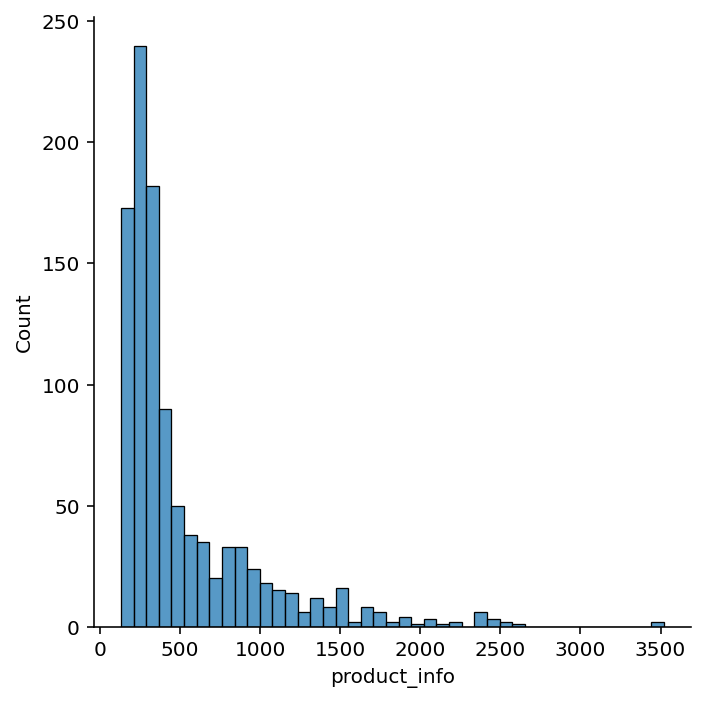

In [10]:
tmp = data.product_info.str.len()
sns.displot(tmp)

/home/ying/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='product_info'>

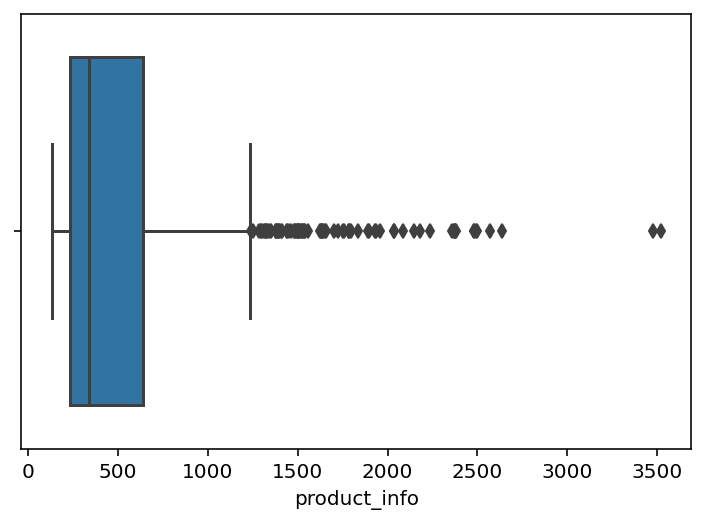

In [11]:
sns.boxplot(tmp)

<span style="color: #00FFFF"> @ On récupère la catégorie principale du produit dans la colonne `product_category_tree `. </span>

## Nettoyer les données

<span style="color: #00FFFF"> @ On récupère le `stopwords` en anglais. </span>

In [12]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/ying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ying/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/ying/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ying/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ying/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<span style="color: #00FFFF"> @ On récupère le `stopwords` en anglais. </span>

In [13]:
from nltk.corpus import stopwords
import os
# extracting the stopwords from nltk library
sw = nltk.download('stopwords')

sw = list(set(stopwords.words('english'))) + ['[', ']', '-',',', '.', ':', '?', '(', ')']

words = set(nltk.corpus.words.words())
lemma = WordNetLemmatizer()
# displaying the stopwords
# np.array(sw)

[nltk_data] Downloading package stopwords to /home/ying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<span style="color: #00FFFF"> @ Fonction de preprocesing (cleaning): Elle va successivement 
- enlever les ponctuations
- enlever les majuscules
- enlever les chiffres
- transformer les phrases en liste de tokens (en liste de mots)
- enlever les stopwords (mots n'apportant pas de sens)
- lemmatizer
- enlever les lettres singulières
- garder seulement les mots présent dans le dictionnaire
- renformer les phrases avec les mots restants  
</span>

In [14]:
import string

def Preprocess_listofSentence(listofSentence, min_len_word):
    preprocess_list = []
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    # w : without
    for sentence in listofSentence :
    
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        #sentence_w_punct = "".join([i.lower() for i in sentence if i.isalnum()])

        sentence_w_num = "".join(i for i in sentence_w_punct if not i.isdigit())
    
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        words_w_stopwords  = [word for word in tokenize_sentence if word not in sw]
    
        words_lemmatize = (lemma.lemmatize(w) for w in words_w_stopwords)

        words_w_single = [w for w in words_lemmatize if w not in list(string.ascii_lowercase)]
        
        words_w_rare = [w for w in words_w_single if len(w)>=min_len_word]

        sentence_clean = ' '.join(w for w in words_w_rare if w in words or not w.isalpha())
    
        preprocess_list.append(sentence_clean)
    
    # joining the list of words with space separator
    return preprocess_list 

In [15]:
import string

def Preprocess_listofSentence_dl(listofSentence, min_len_word):
    preprocess_list = []
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    # w : without
    for sentence in listofSentence :
    
        sentence_w_lower = "".join([i.lower() for i in sentence ])

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_lower)
        words_w_stopwords  = [word for word in tokenize_sentence if word not in sw]
    
        sentence_clean = ' '.join(w for w in words_w_stopwords)
    
        preprocess_list.append(sentence_clean)
    
    # joining the list of words with space separator
    return preprocess_list 

In [16]:
preprocess_list = Preprocess_listofSentence(data['product_info'], 2)          # Each sentence has more than 2 words.
preprocess_list_dl = Preprocess_listofSentence_dl(data['product_info'], 2)    # Each sentence has more than 2 words.

data['product_info_bow'] = preprocess_list
data['product_info_dl'] = preprocess_list_dl

preprocess_list_dl[2]

'eurospa cotton terry face towel set key features eurospa cotton terry face towel set size small height 9 inch gsm 360 eurospa cotton terry face towel set 20 piece face towel set assorted price rs 299 eurospa brings exclusively designed 100 % soft cotton towels export quality products soft texture takes care skin gives enriched feeling deserve eurospa exporting bath towels lot renowned brands last 10 years famous fine prints absorbency softness durability note product 100 % cotton susceptible shrinkage product color may vary picture size may vary ±3 % wash care wash cold water iron bleach flat dry wash first use size- face towel 23 cms x 23 cms. specifications eurospa cotton terry face towel set 20 piece face towel set assorted bath towel features material cotton terry design shuvam general brand eurospa gsm 360 type face towel set model name shuvam20pcftsetassorted ideal boys girls men women model id shuvam20pcftsetassorted size small color assorted dimensions weight 350 g length 9 in

In [17]:
# On affiche la fréquence des mots en utlisant la classe FreqDist
tokens =[]
for i in range(len(preprocess_list)):
    tokens+= nltk.word_tokenize(preprocess_list[i])

freq = nltk.FreqDist(tokens )
freq.most_common(10)

[('product', 863),
 ('free', 616),
 ('buy', 582),
 ('replacement', 568),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('price', 557),
 ('day', 555)]

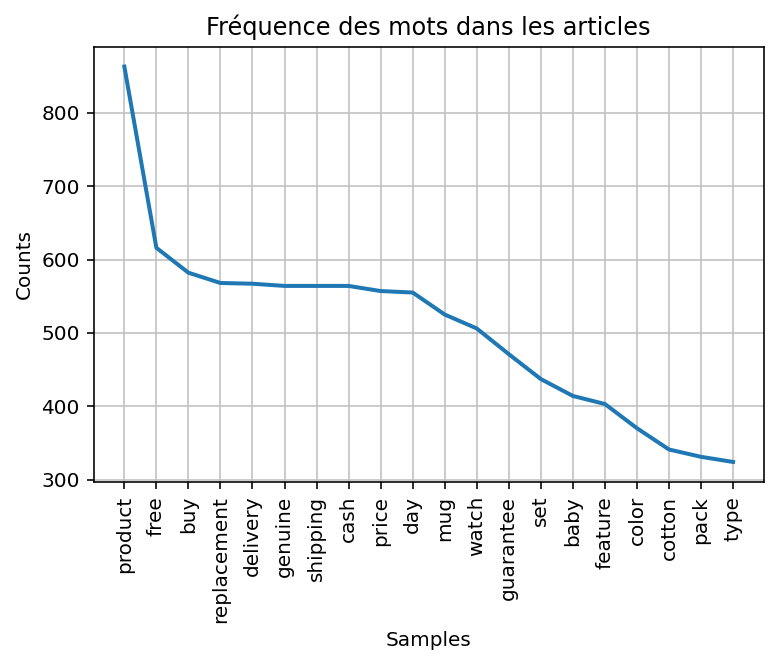

<AxesSubplot:title={'center':'Fréquence des mots dans les articles'}, xlabel='Samples', ylabel='Counts'>

In [122]:
# On affiche la distribution des mots:
freq.plot(20, title="Fréquence des mots dans les articles")

In [19]:
# Attribuer un numéro à la catégorie de chaque produit
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data["category_num"] = le.fit_transform(data["category_major"])
cat_num = data["category_num"].tolist()

In [20]:
data.category_num.value_counts()

4    150
0    150
6    150
3    150
5    150
1    150
2    150
Name: category_num, dtype: int64

### 
- 0 – Baby Care 
- 1 – Beauty and Personal Care
- 2 – Computers
- 3 –Home Décor & Festive Needs 
- 4 – Home Furnishing 
- 5 – Kitchen & Dining
- 6 – Watches

In [21]:
# Méthode 2 : Attribuer un numéro à la catégorie de chaque produit
# list_cat = list(set(data['category_major']))
# print("catégories : ", list_cat)
# cat_num = [list_cat.index(data.iloc[i]['category_major']) for i in range(len(data))]
# data["cat_num"] = [list_cat.index(data.iloc[i]['category_major']) for i in range(len(data))]

In [22]:
# Méthode 3 : Attribuer un numéro à la catégorie de chaque produit
# codes, uniques = pd.factorize(data["category_major"])
# data['category_number']= codes

In [23]:
list_cat = list(set(data['category_major']))  # set : unique

In [24]:
from nltk.tokenize import sent_tokenize, word_tokenize

data['length_d'] = data['product_info'].apply(lambda x : len(word_tokenize(x)))
data['length_bow'] = data['product_info_bow'].apply(lambda x : len(word_tokenize(x)))
data['length_dl'] = data['product_info_dl'].apply(lambda x : len(word_tokenize(x)))

In [25]:
data = data[['category_major', 'category_num','product_info', 'length_d','product_info_bow','length_bow',
       'product_info_dl',  'length_dl','image']]

In [26]:
data.describe()

category_num     length_d   length_bow    length_dl
count   1050.000000  1050.000000  1050.000000  1050.000000
mean       3.000000    94.800952    46.358095    65.631429
std        2.000953    84.951965    41.230610    53.416474
min        0.000000    23.000000     9.000000    17.000000
25%        1.000000    42.000000    18.000000    31.000000
50%        3.000000    60.500000    30.000000    44.000000
75%        5.000000   113.750000    62.000000    84.750000
max        6.000000   644.000000   329.000000   394.000000

In [27]:
data.to_csv("data_cleaned.csv",index=False)

## Fonctions communes

In [28]:
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(list_cat)
    #
  
    for p in [5,10,20,30,40,50]:
        tsne = manifold.TSNE(n_components=2, perplexity=p, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
        X_tsne = tsne.fit_transform(features)
        
         # Détermination des clusters à partir des données après Tsne 
        cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
        cls.fit(X_tsne)
        ARI = np.round(metrics.adjusted_rand_score(cat_num, cls.labels_),4)
        time2 = np.round(time.time() - time1,0)
      
        print("ARI : ", ARI,"Perplexity : ", p,  "time : ", time2) 
    
  
    return ARI, X_tsne, cls.labels_

In [29]:
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn import mixture

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct_mixture(features) :
    time1 = time.time()
    num_labels=len(list_cat)
    #
  
    for p in [5,10,20,30,40,50]:
        tsne = manifold.TSNE(n_components=2, perplexity=p, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
        X_tsne = tsne.fit_transform(features)
        
         # Détermination des clusters à partir des données après Tsne 
        cls = mixture.GaussianMixture(n_components=7)
        cls.fit(X_tsne)
        ARI = np.round(metrics.adjusted_rand_score(cat_num, cls.predict(X_tsne)),4)
        time2 = np.round(time.time() - time1,0)
      
        print("ARI : ", ARI,"Perplexity : ", p,  "time : ", time2) 
    
  
    return ARI, X_tsne, cls.predict(X_tsne)

In [30]:
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct_opt(features,p) :
    time1 = time.time()
    num_labels=len(list_cat)
    #
  
    tsne = manifold.TSNE(n_components=2, perplexity=p, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    
    return ARI, X_tsne, cls.labels_

In [31]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
   
    
    plt.show()
    print("ARI : ", ARI)

## One-hot Encoding : Bag of words & tf-idf

<span style="color: #00FFFF"> @ Bag of words 
- Nous allons vectoriser nos mots.
</span>


In [32]:
sentences = preprocess_list

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bow = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)

bow_mat = vectorizer_bow.fit_transform(sentences)

feature_names= vectorizer_bow.get_feature_names()
df_bow = pd.DataFrame(bow_mat.toarray(), columns=feature_names)

/home/ying/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# La taille de dictionnaire , set : unique mot
len(set(vectorizer_bow.get_feature_names()))

2963

<span style="color: #00FFFF"> @ tf-idf </span>

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tf_idf  = TfidfVectorizer(stop_words='english',  max_df=0.95, min_df=1)

tfidf_mat = vectorizer_tf_idf.fit_transform(sentences)

feature_names = vectorizer_tf_idf.get_feature_names()
dense = tfidf_mat.todense() # convert sparse matrix to numpy array
denselist = dense.tolist() # convert array to list
df_tf_idf = pd.DataFrame(denselist, columns=feature_names)

In [36]:
len(set(vectorizer_tf_idf.get_feature_names()))

2963

In [37]:
df_tf_idf;

## Exécution des modèles

In [38]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(bow_mat)
print()

print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(tfidf_mat)

CountVectorizer : 
-----------------
ARI :  0.2636 Perplexity :  5 time :  14.0
ARI :  0.3283 Perplexity :  10 time :  25.0
ARI :  0.4698 Perplexity :  20 time :  38.0
ARI :  0.4341 Perplexity :  30 time :  56.0
ARI :  0.4621 Perplexity :  40 time :  74.0
ARI :  0.4779 Perplexity :  50 time :  89.0

Tf-idf : 
--------
ARI :  0.3566 Perplexity :  5 time :  8.0
ARI :  0.4656 Perplexity :  10 time :  17.0
ARI :  0.5697 Perplexity :  20 time :  26.0
ARI :  0.5044 Perplexity :  30 time :  36.0
ARI :  0.4786 Perplexity :  40 time :  48.0
ARI :  0.4168 Perplexity :  50 time :  60.0


In [39]:
print("CountVectorizer avec Mixture: ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct_mixture(bow_mat)
print()

print("Tf-idf avec Mixture: ")
print("--------")
ARI, X_tsne, labels = ARI_fct_mixture(tfidf_mat)

CountVectorizer avec Mixture: 
-----------------
ARI :  0.1987 Perplexity :  5 time :  9.0
ARI :  0.3727 Perplexity :  10 time :  23.0
ARI :  0.4918 Perplexity :  20 time :  35.0
ARI :  0.3431 Perplexity :  30 time :  48.0
ARI :  0.3952 Perplexity :  40 time :  61.0
ARI :  0.3677 Perplexity :  50 time :  74.0

Tf-idf avec Mixture: 
--------
ARI :  0.3311 Perplexity :  5 time :  22.0
ARI :  0.4278 Perplexity :  10 time :  40.0
ARI :  0.562 Perplexity :  20 time :  55.0
ARI :  0.4208 Perplexity :  30 time :  69.0
ARI :  0.3844 Perplexity :  40 time :  82.0
ARI :  0.3937 Perplexity :  50 time :  96.0


#### Il semblerait que la meilleure valeur de perplexity soit 20 dans notre cas.

In [40]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct_opt(bow_mat,20)
print()

print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct_opt(tfidf_mat,20)

CountVectorizer : 
-----------------
ARI :  0.4698 time :  14.0

Tf-idf : 
--------
ARI :  0.5697 time :  14.0


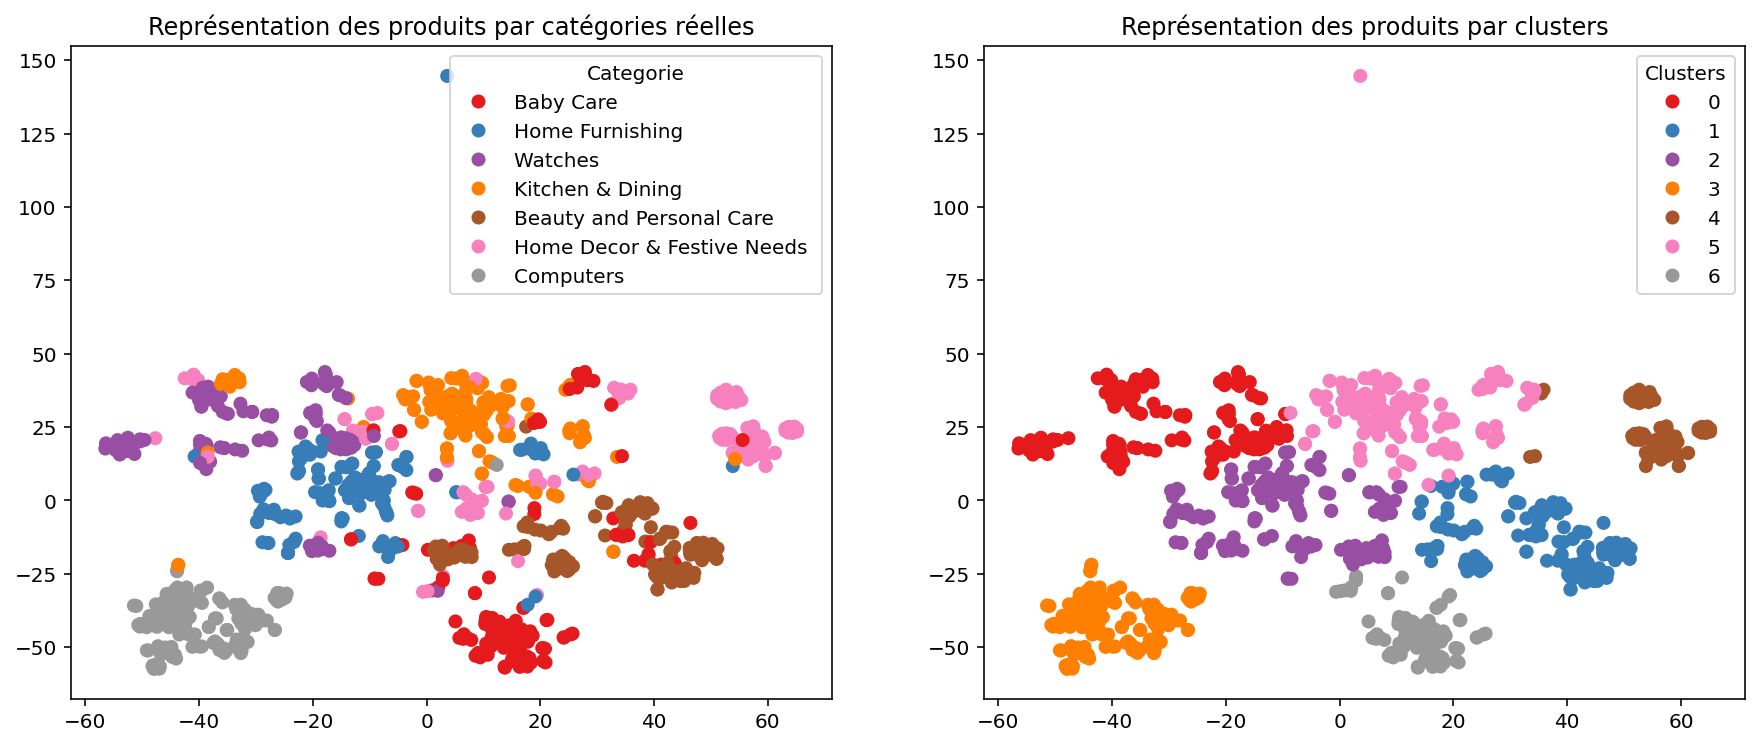

ARI :  0.5697


In [41]:
TSNE_visu_fct(X_tsne, cat_num, labels, ARI)

In [42]:
# on sépare en apprentissage/validation
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(sentences,cat_num,test_size=0.2)

trans_vect=TfidfVectorizer()
x_train_trans=trans_vect.fit_transform(x_train)
x_test_trans=trans_vect.transform(x_test)

In [43]:
from sklearn.naive_bayes import MultinomialNB
# on définit deux modèles
modele_bayes=MultinomialNB()
modele_bayes.fit(x_train_trans, y_train)

MultinomialNB()

In [44]:
# on vérifie la qualité du modèle sur les données de vaildation
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
print("Accuracy pour naive Bayes:",
accuracy_score(y_test, modele_bayes.predict(x_test_trans)))

Accuracy pour naive Bayes: 0.8761904761904762


## Word Embedding : Word2Vec

In [45]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

- `sentences` attend une liste de listes avec les documents tokenisés.
- `vector_size` définit la taille des vecteurs de mots. Dans ce cas, vous le réglez sur 100.
- `workers` définit le nombre de cœurs que vous utilisez pour la formation. Je l'ai mis à 1 pour m'assurer que le code est reproductible de manière déterministe.
- `seed` graine pour générateur de nombres aléatoires. Il est défini sur la constante SEED que vous avez définie dans la première cellule.

## Création du modèle Word2Vec

In [46]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 330 # adapt to length of sentences

In [47]:
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [48]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count = w2v_min_count, 
                                   window = w2v_window,
                                   vector_size = w2v_size,
                                   seed = 42,
                                   workers = 1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3072
Word2Vec trained


In [49]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3073


In [50]:
print(x_sentences.ndim, x_sentences.shape, x_sentences[1].shape)

2 (1050, 330) (330,)


## Création de la matrice d'embedding

In [51]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

print(i,j)
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
3072 3072
Word embedding rate :  1.0
Embedding matrix: (3073, 300)


## Création du modèle d'embedding

In [52]:
from keras.layers import Embedding, Flatten, Dense
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
                         
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 330)]             0         
                                                                 
 embedding (Embedding)       (None, 330, 300)          921900    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 921,900
Trainable params: 921,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [53]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 7ms/step


(1050, 300)

In [54]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.3187 Perplexity :  5 time :  11.0
ARI :  0.3566 Perplexity :  10 time :  20.0
ARI :  0.3455 Perplexity :  20 time :  30.0
ARI :  0.4178 Perplexity :  30 time :  42.0
ARI :  0.3944 Perplexity :  40 time :  54.0
ARI :  0.4066 Perplexity :  50 time :  71.0


In [55]:
ARI, X_tsne, labels = ARI_fct_opt(embeddings,30)

ARI :  0.4178 time :  14.0


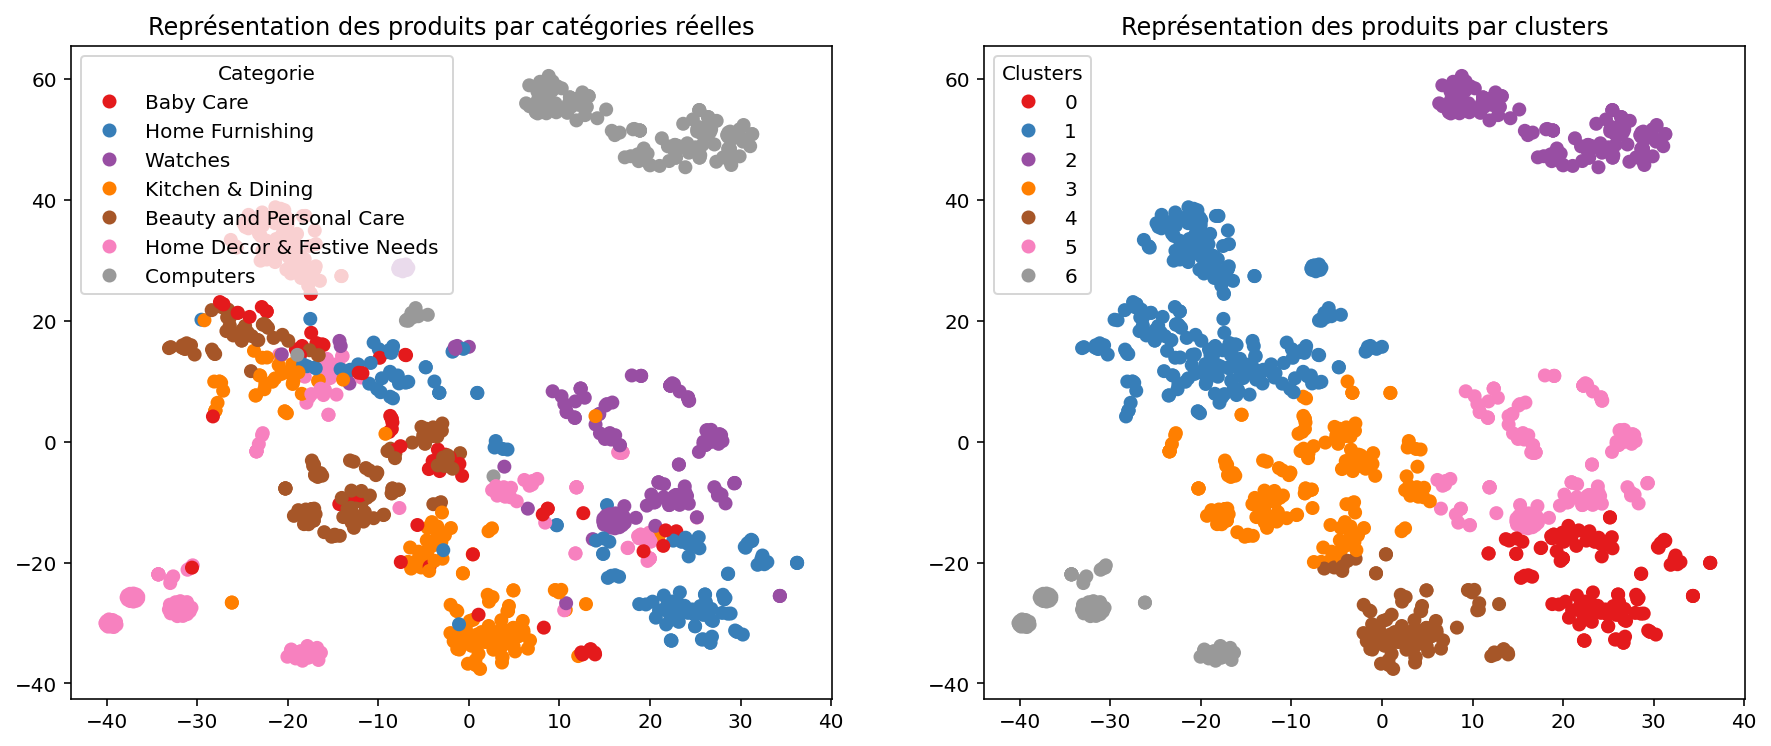

ARI :  0.4178


In [56]:
TSNE_visu_fct(X_tsne, cat_num, labels, ARI)

# BERT

In [57]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [58]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


## Fonctions communes

In [59]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
 

In [60]:
# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [61]:
max_length = 64
batch_size = 7
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences_dl = preprocess_list_dl

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/ying/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncas

In [62]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences_dl, 
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/ying/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resol

1/1 [==============================] - 1s 1s/step
temps traitement :  244.0


In [63]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4281 Perplexity :  5 time :  9.0
ARI :  0.4759 Perplexity :  10 time :  18.0
ARI :  0.3742 Perplexity :  20 time :  27.0
ARI :  0.4035 Perplexity :  30 time :  40.0
ARI :  0.4015 Perplexity :  40 time :  53.0
ARI :  0.3466 Perplexity :  50 time :  64.0


In [64]:
ARI, X_tsne, labels = ARI_fct_opt(features_bert,10)

ARI :  0.4759 time :  9.0


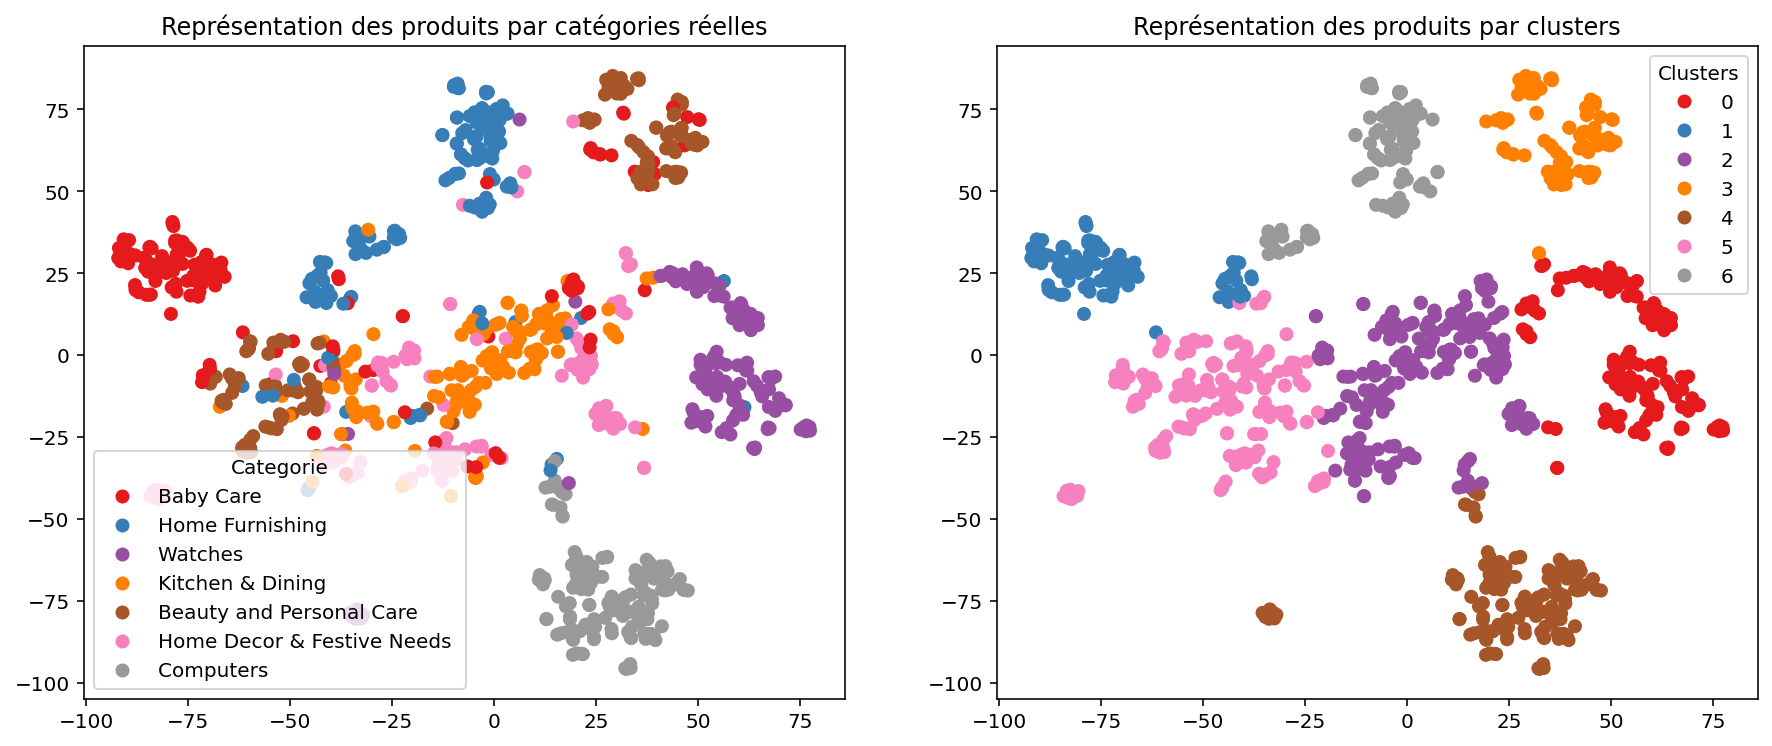

ARI :  0.4759


In [65]:
TSNE_visu_fct(X_tsne, cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [66]:
max_length = 64
batch_size = 7
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)

loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at /home/ying/.cache/huggingface/transformers/7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention

In [67]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences_dl,
                                                         max_length, batch_size, mode='HF')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at /home/ying/.cache/huggingface/transformers/7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_no

1/1 [==============================] - 1s 1s/step
temps traitement :  260.0


In [68]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2241 Perplexity :  5 time :  9.0
ARI :  0.2337 Perplexity :  10 time :  19.0
ARI :  0.2367 Perplexity :  20 time :  29.0
ARI :  0.2328 Perplexity :  30 time :  40.0
ARI :  0.2115 Perplexity :  40 time :  51.0
ARI :  0.2126 Perplexity :  50 time :  63.0


In [69]:
ARI, X_tsne, labels = ARI_fct_opt(features_bert, 20)

ARI :  0.2367 time :  10.0


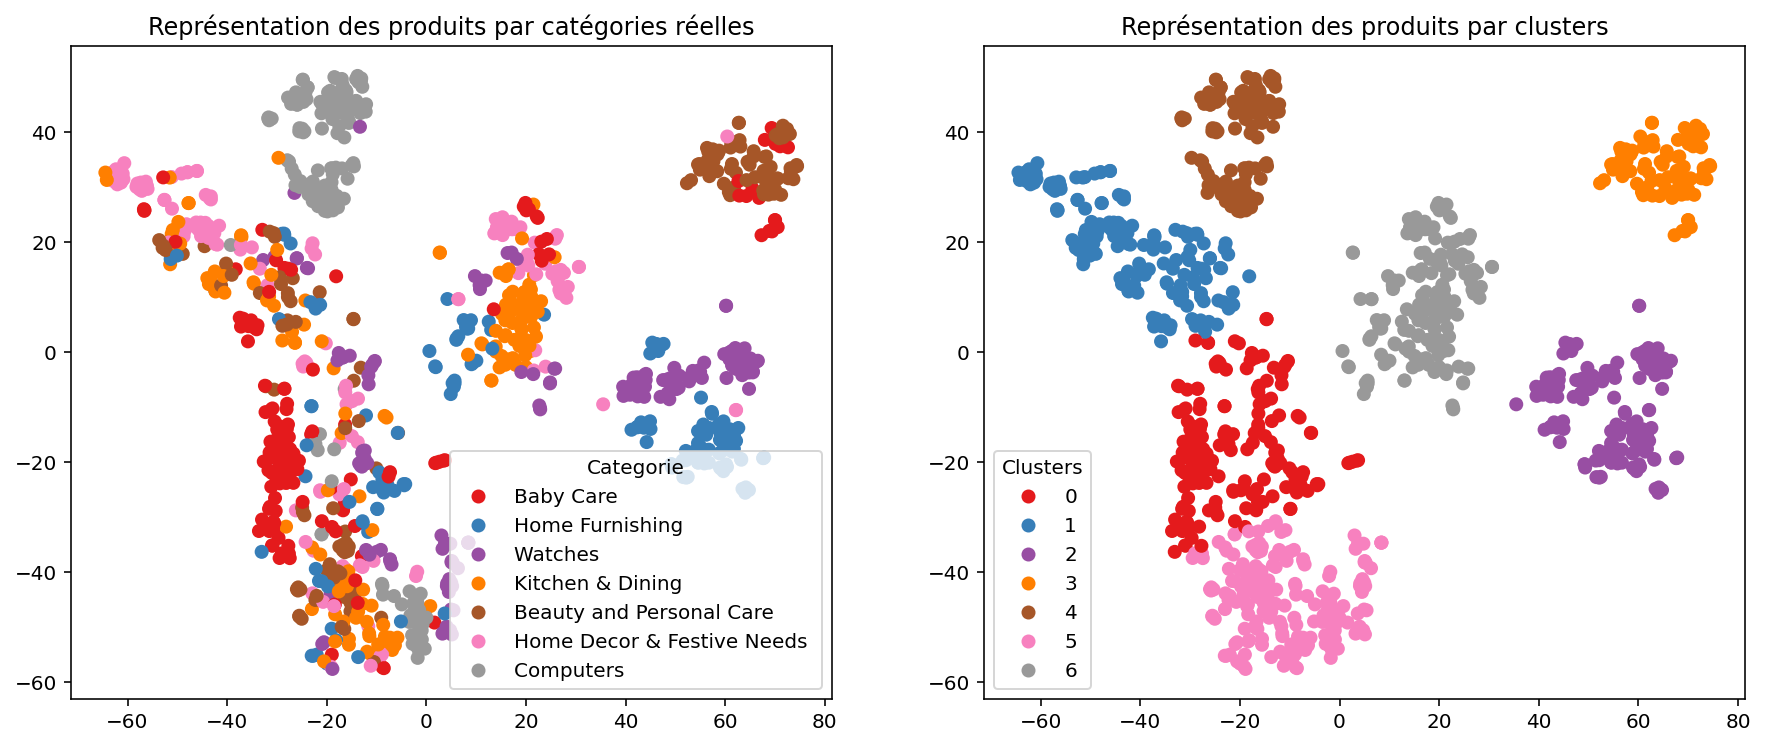

ARI :  0.2367


In [70]:
TSNE_visu_fct(X_tsne, cat_num, labels, ARI)

## BERT hub Tensorflow

In [71]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [72]:
max_length = 64
batch_size = 70 
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences_dl, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/ying/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resol

temps traitement :  186.0


In [73]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.368 Perplexity :  5 time :  10.0
ARI :  0.3956 Perplexity :  10 time :  20.0
ARI :  0.4097 Perplexity :  20 time :  30.0
ARI :  0.3434 Perplexity :  30 time :  41.0
ARI :  0.3782 Perplexity :  40 time :  54.0
ARI :  0.3823 Perplexity :  50 time :  67.0


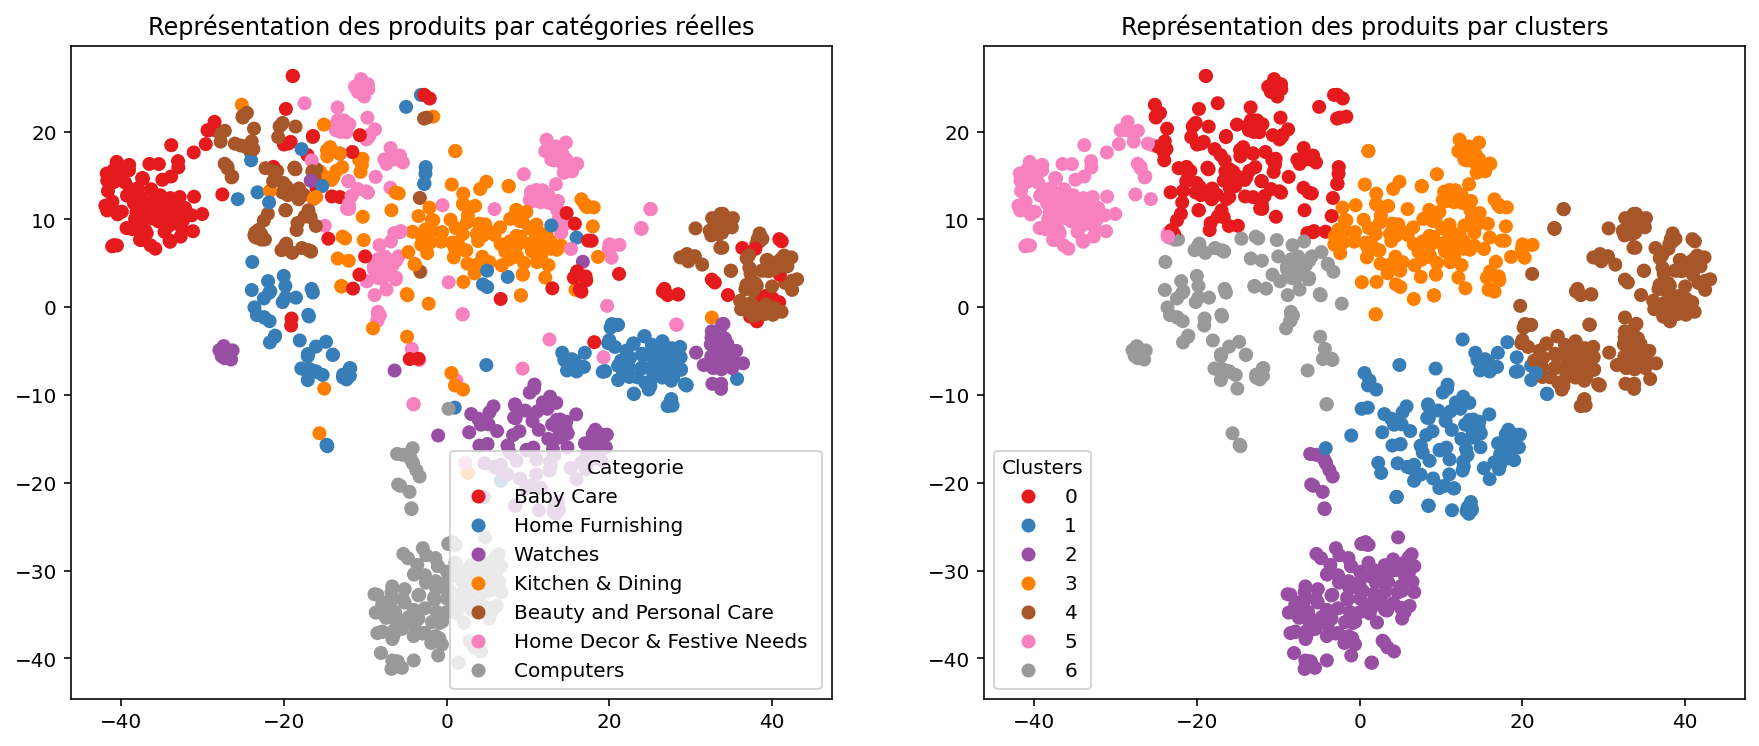

ARI :  0.3823


In [74]:
TSNE_visu_fct(X_tsne, cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [75]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [76]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [77]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [78]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [79]:
batch_size = 70
features_USE = feature_USE_fct(sentences_dl, batch_size)

In [80]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.3532 Perplexity :  5 time :  11.0
ARI :  0.5054 Perplexity :  10 time :  22.0
ARI :  0.4418 Perplexity :  20 time :  32.0
ARI :  0.466 Perplexity :  30 time :  43.0
ARI :  0.4373 Perplexity :  40 time :  55.0
ARI :  0.5089 Perplexity :  50 time :  67.0


In [81]:
ARI, X_tsne, labels = ARI_fct_opt(features_USE, 50)

ARI :  0.5089 time :  17.0


In [82]:
from sklearn.metrics import accuracy_score
print ("Précision: %s" % accuracy_score(cat_num, labels ))

Précision: 0.24571428571428572


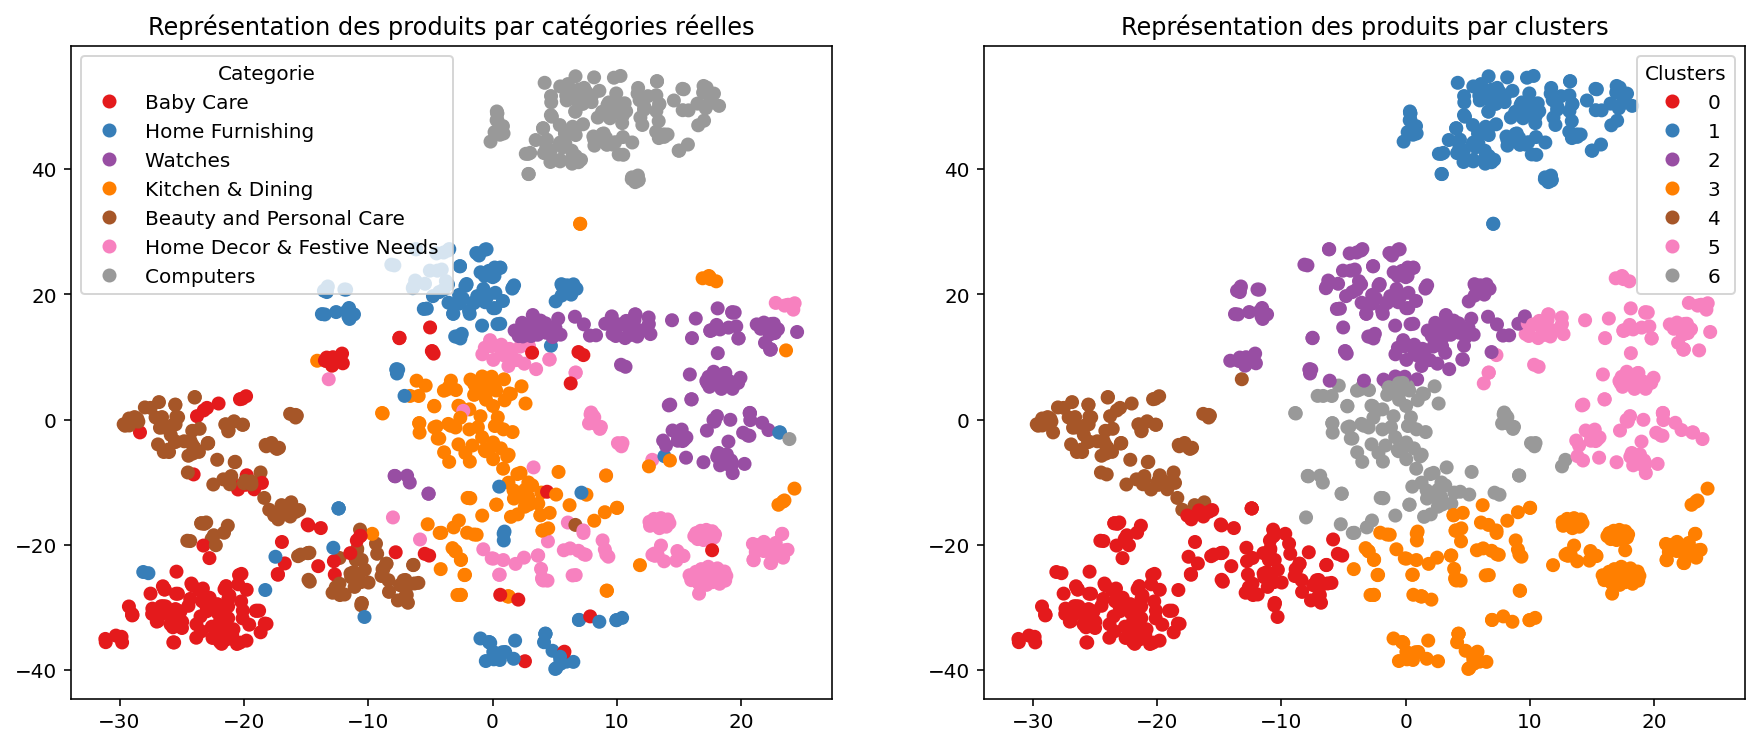

ARI :  0.5089


In [83]:
TSNE_visu_fct(X_tsne, cat_num, labels, ARI)

## Conclusion : text clustering
    - 1° : Tf-idf 
    - 2° : USE
    - 3° : BERT
    - 4° : Word2Vec
    - 5° : Berthub TensorFlow
    - 6° : BertHugging Fact

# Classification des images

In [84]:
import numpy as np
import pandas as pd
import string


# Pour visualisation
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# import seaborn as sns
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Pour NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize

# Pour Machine Learing - classification
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.metrics.cluster import adjusted_rand_score

In [85]:
import pandas as pd
data_cleaned = pd.read_csv('data_cleaned.csv', sep=',')
list_cat = list(set(data_cleaned['category_major']))
# Trie la colonne `image` du dataset 'data' 
data_cleaned = data_cleaned.sort_values(by=['image'], ascending=True)
data_cleaned = data_cleaned.reset_index()

In [86]:
import os

list_photos = os.listdir('./Images')
len(list_photos)
list_photos[5]

'00ed03657cedbe4663eff2d7fa702a33.jpg'

Baby Care 


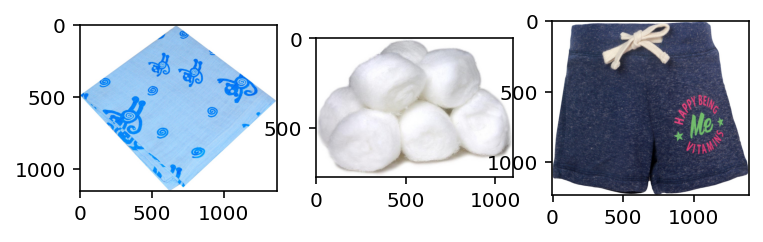

Home Furnishing 


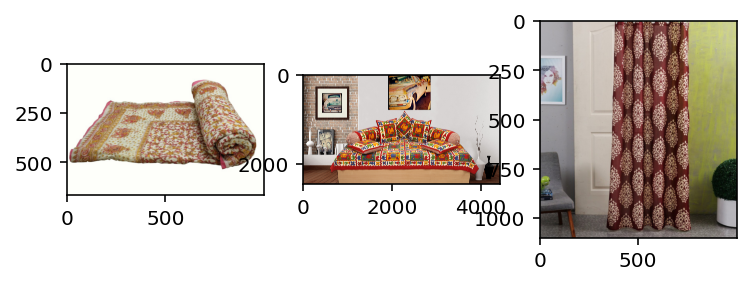

Watches 


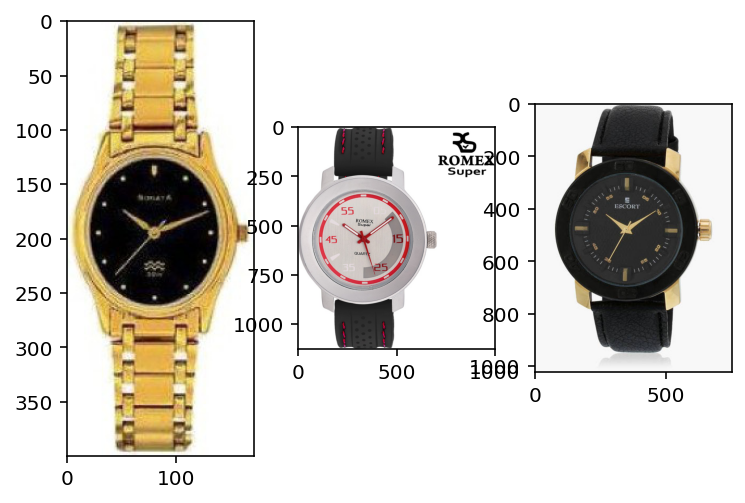

Kitchen & Dining 


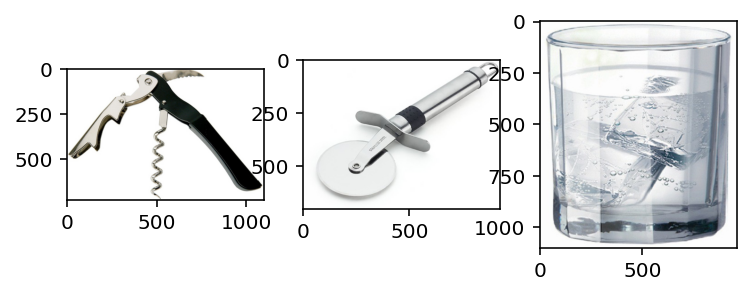

Beauty and Personal Care 


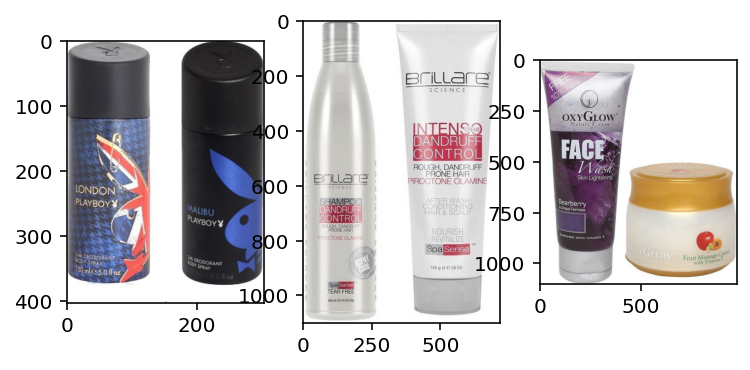

Home Decor & Festive Needs 


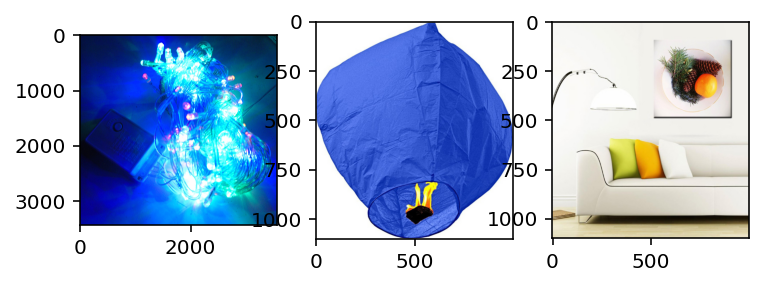

Computers 


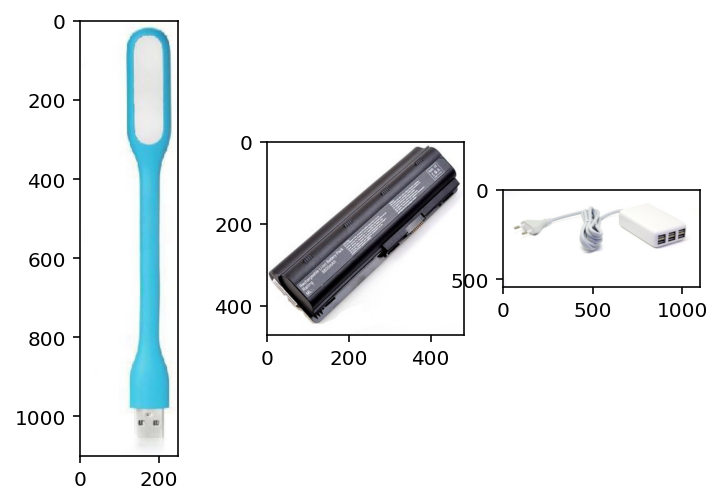

In [87]:
from matplotlib.image import imread

# Function to define image list for each category
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]==name]
    return list_image_name

# Create image list for each category
list_baby=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Baby Care']
list_beauty=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Beauty and Personal Care']
list_computers=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Computers ']
list_home_decor=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Home Decor & Festive Needs']
list_home_furnishing=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Home Furnishing']
list_kitchen=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Kitchen & Dining']
list_watches=[list_photos[i] for i in range(len(data_cleaned)) if data_cleaned["category_major"][i]=='Watches']

# Show 3 images for each category
for category in list_cat :
    print(category)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = './Images/' + list_fct(category)[i+5]
        image = imread(filename)
        
        plt.imshow(image)
    plt.show()

## Visualiser l'histrogramme d'une image coleur :

In [88]:
import cv2 
def histogramOpenCV(img):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    axis[0].imshow(img)
    axis[1].set_title('Histogram')
    axis[0].set_title('Image')
    rgbcolors = ['red', 'green', 'blue']
    for i,col in enumerate(rgbcolors):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        axis[1].plot(histr,color = col)

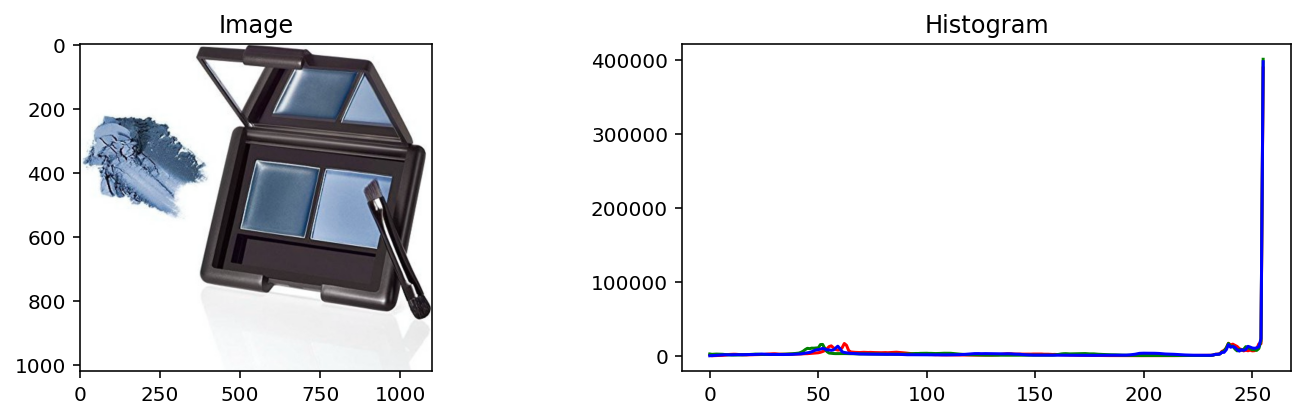

In [89]:
s= np.random.randint(1005)       # s=600
image = cv2.imread('./Images/'+list_photos[s])  
histogramOpenCV(image)

## Extraction des caractéristiques

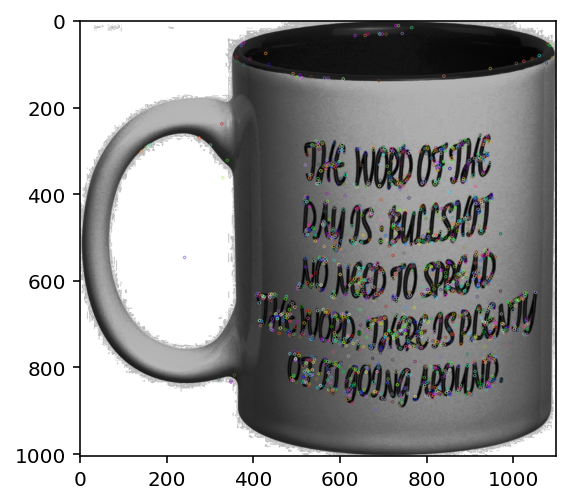

Descripteurs :  (2212, 128)

[[24.  0.  0. ...  0.  1.  3.]
 [21.  1.  0. ...  0.  0.  4.]
 [11.  0.  0. ...  0.  0.  3.]
 ...
 [30.  0.  0. ...  0.  0. 12.]
 [15.  0.  0. ...  0.  0.  4.]
 [47. 54. 10. ...  3.  2.  0.]]


In [121]:
import cv2 

# charge le fichier dans une matrice de pixels gris
s= np.random.randint(1005)
image_Gray = cv2.imread('./Images/'+list_photos[s],0)  

# Initialiser le SIFT détecteur
sift = cv2.SIFT_create()

image = cv2.equalizeHist(image_Gray)   # equalize image histogram

#  Les caractéristiques sont extraites pour obtenir les clés et les descripteurs correspondants （Vecteur caractéristique）
keyPoint, descriptor = sift.detectAndCompute(image_Gray, None) 


img=cv2.drawKeypoints(image,keyPoint,image_Gray)
plt.imshow(img)
plt.show()
print("Descripteurs : ", descriptor.shape)
print()
print(descriptor)


## SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [91]:
# Split list_photos into 4 list for further treatment
splits = np.array_split(list_photos, 4)

list1 = splits[0]
list2 = splits[1]
list3 = splits[2]
list4 = splits[3]

In [92]:
# identification of key points and associated descriptors in list_photos
import time, cv2

temps1=time.time()
# Limit the number of descriptors for each image : 1000
sift = cv2.SIFT_create(1000)

# Apply pre processing and descriptors creation for list1
sift_keypoints1 = []
for image_num in range(len(list1)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread('./images/'+list_photos[image_num])
    # convert in gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints1.append(des)

# Apply pre processing and descriptors creation for list2
sift_keypoints2 = []
for image_num in range(len(list2)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread('./images/'+list_photos[image_num])
    # convert in gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints2.append(des)

# Apply pre processing and descriptors creation for list3
sift_keypoints3 = []
for image_num in range(len(list3)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread('./images/'+list_photos[image_num])
    # convert in gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints3.append(des)

# Apply pre processing and descriptors creation for list4
sift_keypoints4 = []
for image_num in range(len(list4)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread('./images/'+list_photos[image_num])
    # convert in gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints3.append(des)
    
# Concatenate sift_keypoints in one list
sift_keypoints = (sift_keypoints1 + sift_keypoints2 + sift_keypoints3 + sift_keypoints4)

# Create a list of descriptors for each image 
sift_keypoints_by_img = np.asarray(sift_keypoints)

# Create a list of descriptors of all images 
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
0
100
200
0
100
200
0
100
200


<ipython-input-92-9701ee093fbb>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (989508, 128)
temps de traitement SIFT descriptor :           817.29 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [93]:
from sklearn import cluster, metrics

temps1=time.time()

# Determination number of clusters (using square root of the number of descriptors)
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size = 3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  995
Création de 995 clusters de descripteurs ...
temps de traitement kmeans :            21.61 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [94]:
# Creation of histograms (features)
temps1=time.time()

# Function to build histogram of 1 image
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

# define the matrix of histograms
im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             7.14 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [95]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 995)
Dimensions dataset après réduction PCA :  (1050, 218)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [96]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_cleaned["category_major"]
print(df_tsne.shape)


/home/ying/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

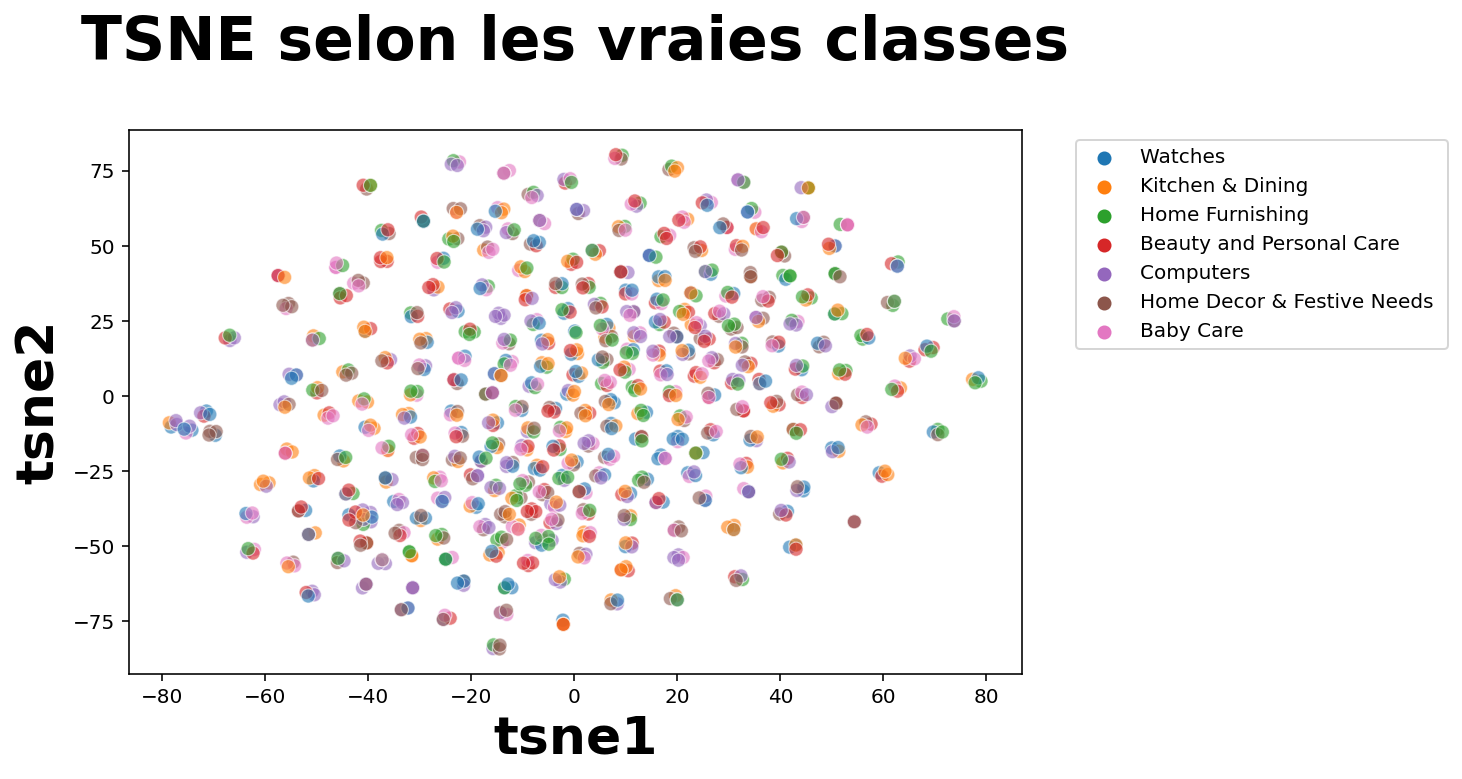

In [97]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [98]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

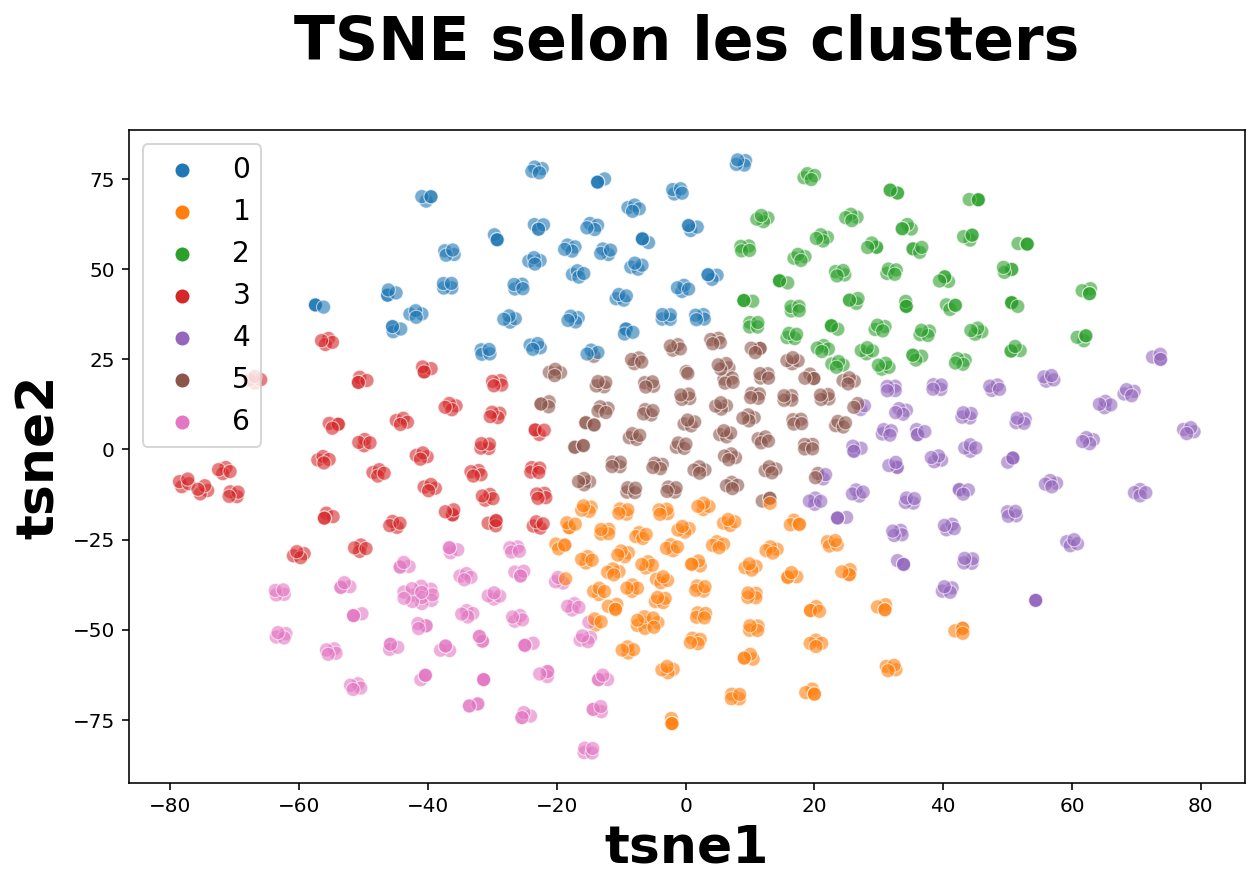

ARI :  0.0027952587986955616


In [99]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data_cleaned["category_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [100]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    135
1    189
2    156
3    124
4    140
5    174
6    132
Name: class, dtype: int64

In [101]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[23 24 30 16 15 23 19]
 [26 26 23 12 27 24 12]
 [19 33 15 16 17 21 29]
 [19 30 19 22 22 19 19]
 [21 23 32  9 18 29 18]
 [14 26 19 31 17 28 15]
 [13 27 18 18 24 30 20]]


In [102]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0,4,5,6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 1, 2, 0, 4, 5, 6]
[[16 24 30 23 15 23 19]
 [12 26 23 26 27 24 12]
 [16 33 15 19 17 21 29]
 [22 30 19 19 22 19 19]
 [ 9 23 32 21 18 29 18]
 [31 26 19 14 17 28 15]
 [18 27 18 13 24 30 20]]

              precision    recall  f1-score   support

           0       0.13      0.11      0.12       150
           1       0.14      0.17      0.15       150
           2       0.10      0.10      0.10       150
           3       0.14      0.13      0.13       150
           4       0.13      0.12      0.12       150
           5       0.16      0.19      0.17       150
           6       0.15      0.13      0.14       150

    accuracy                           0.14      1050
   macro avg       0.13      0.14      0.13      1050
weighted avg       0.13      0.14      0.13      1050



<AxesSubplot:>

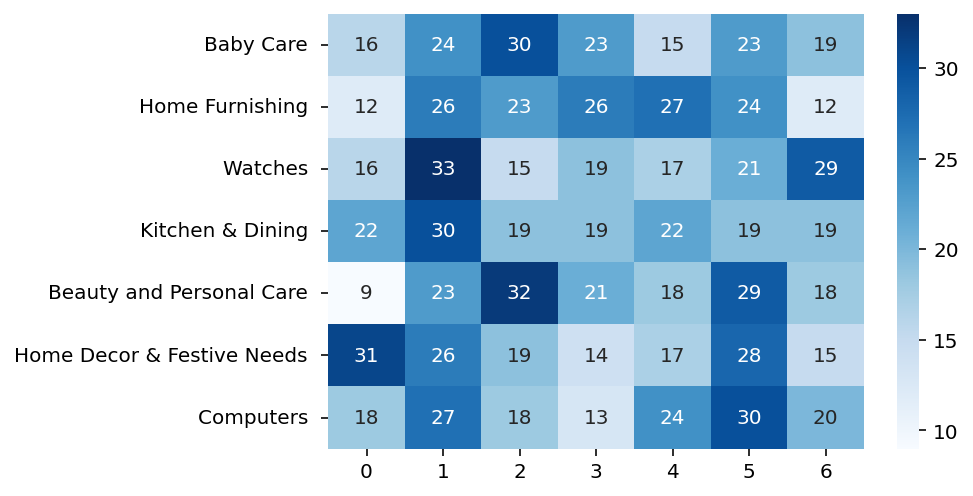

In [103]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

""""""""""""""""""""""""""""""""""""""

## CNN Transfer learning : VGG16

In [104]:
import numpy as np
from sklearn import cluster, metrics
from keras import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from tensorflow.keras.preprocessing import image

In [105]:
# load model
model_vgg16 = VGG16()
# remove the output layer
model_vgg16 = Model(inputs = model_vgg16.inputs,
                    outputs = model_vgg16.layers[-2].output)
# summarize the model
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [106]:
vgg16_feature_list = []

for i, fname in enumerate(list_photos):

    img = image.load_img('./Images/'+list_photos[i], target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data =preprocess_input(img_data)
    

    vgg16_feature = model_vgg16.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())    
    
        
vgg16_feature_list_np = np.array(vgg16_feature_list)

1/1 [==============================] - 0s 366ms/step


/home/ying/.local/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 363ms/step


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [107]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", vgg16_feature_list_np.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [108]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_cleaned["category_major"]
print(df_tsne.shape)


/home/ying/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

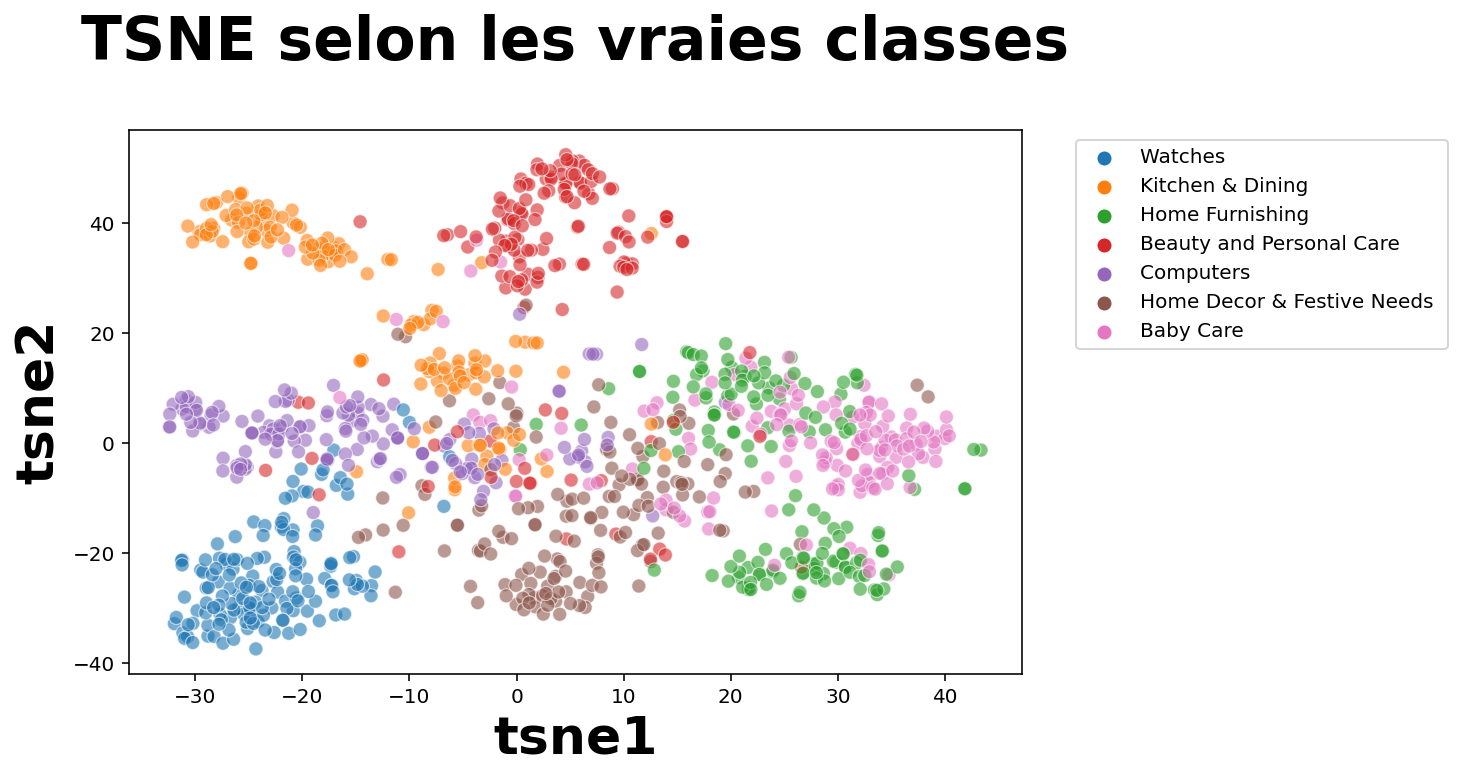

In [109]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [110]:
from sklearn import cluster, metrics

kmeans = cluster.KMeans(n_clusters=7, random_state=6).fit(vgg16_feature_list_np)


df_tsne["cluster"] = kmeans.labels_
print(df_tsne.shape)


(1050, 4)


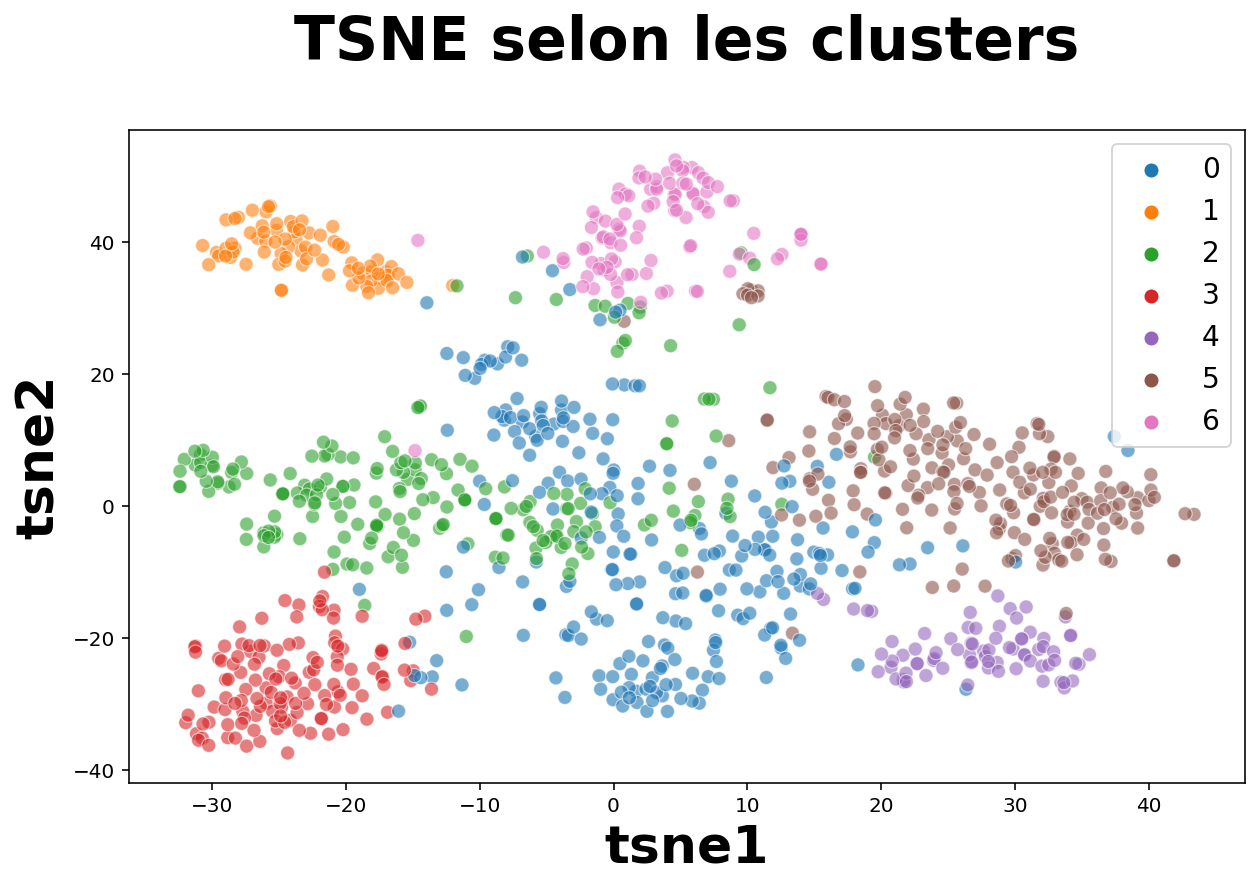

ARI :  0.48308502468981734


In [111]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data_cleaned["category_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, kmeans.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [112]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    255
1     77
2    206
3    129
4     76
5    209
6     98
Name: class, dtype: int64

In [113]:
conf_mat = metrics.confusion_matrix(labels, kmeans.labels_)
print(conf_mat)

[[ 23   1   4   0  10 110   2]
 [ 18   0  24   0   1  13  94]
 [  7   0 142   0   0   0   1]
 [138   0   4   2   3   3   0]
 [  6   0   0   0  62  82   0]
 [ 55  76  17   0   0   1   1]
 [  8   0  15 127   0   0   0]]


In [114]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0,4,5,6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, kmeans.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 1, 2, 0, 4, 5, 6]
[[  0   1   4  23  10 110   2]
 [  0   0  24  18   1  13  94]
 [  0   0 142   7   0   0   1]
 [  2   0   4 138   3   3   0]
 [  0   0   0   6  62  82   0]
 [  0  76  17  55   0   1   1]
 [127   0  15   8   0   0   0]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.00      0.00      0.00       150
           2       0.69      0.95      0.80       150
           3       0.54      0.92      0.68       150
           4       0.82      0.41      0.55       150
           5       0.00      0.01      0.01       150
           6       0.00      0.00      0.00       150

    accuracy                           0.33      1050
   macro avg       0.29      0.33      0.29      1050
weighted avg       0.29      0.33      0.29      1050



<AxesSubplot:>

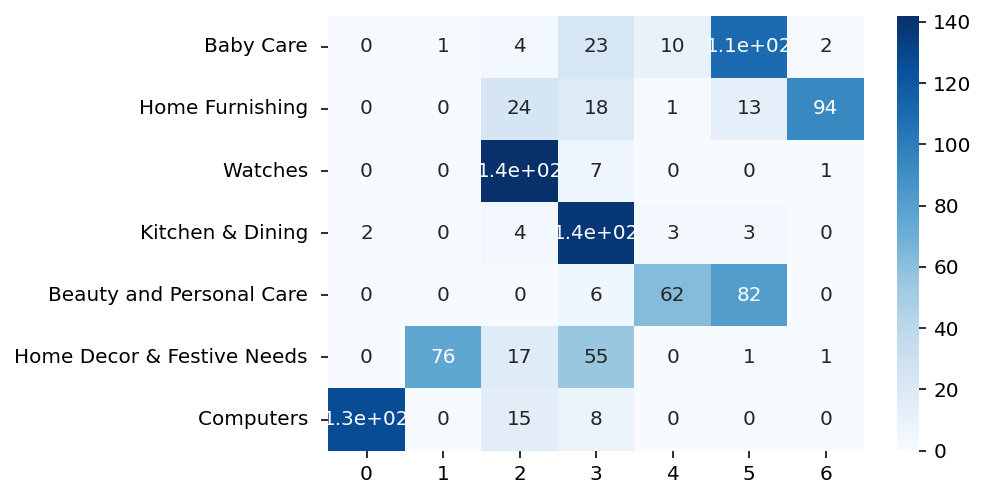

In [115]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Conclusion : text clustering
    - 1° : CNN Transfer learning: VGG16
    - 2° : SIFT
  